In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

#Loading the data
df = pd.read_csv('College_Data.csv')

In [171]:
#Cleaning College Name
def clean_college_name(college_name):
    # Use regex to remove everything after the comma, including the comma itself
    return college_name.split(',')[0]

#Converting Fee to Integer
def convert_fee_to_int(fee):
    if fee is None or fee != fee:  # Check for NaN (because NaN != NaN in Python)
        return None
    
    if isinstance(fee, str):
        # Remove the rupee symbol (₹) and any leading/trailing whitespace
        fee = fee.replace('₹', '').strip()
        
        # Handle the 'K' (thousands) and 'L' (lakh) cases
        if 'K' in fee:
            # Convert the remaining value to float and multiply by 1000 (thousands)
            return int(float(fee.replace('K', '').strip()) * 1000)
        elif 'L' in fee:
            # Convert the remaining value to float and multiply by 100000 (lakh)
            return int(float(fee.replace('L', '').strip()) * 100000)
        else:
            # If no 'K' or 'L', just convert the fee to an integer
            return int(float(fee))  # This will ensure it’s an integer, even if there’s a decimal
    elif isinstance(fee, (int, float)):
        # If it's already a number, convert it to int
        return int(fee)
    else:
        # Handle any other types, raise a ValueError if needed
        raise ValueError("Invalid fee format")

In [172]:
#Appling clean-up functions
df['College Name'] = df['College Name'].apply(clean_college_name)
df['Location'] = df['Location'].str.lstrip(',')
df['Location'] = df['Location'].replace('', np.nan)
df['Location'] = df['Location'].fillna('Unknown')
df['Fee Structure'] = df['Fee Structure'].apply(convert_fee_to_int)
df['Seats'] = pd.to_numeric(df['Seats'], errors='coerce').astype('Int64')
df['Facilities'] = df['Facilities'].str.lstrip(',')

In [173]:
#Initializing the KNNImputer
knn_imputer = KNNImputer(n_neighbors = 5)

df[['Fee Structure', 'Seats']] = knn_imputer.fit_transform(df[['Fee Structure', 'Seats']])

df['Seats'] = df['Seats'].astype(int)

In [174]:
#Filling missing values for other columns
df['Duration'] = df['Duration'].fillna(df['Duration'].mode()[0])
df['Facilities'] = df['Facilities'].fillna(df['Facilities'].mode()[0])
df['Rating'] = df['Rating'].fillna(df['Rating'].mode())[0]

missing_percentage_after = df.isnull().mean() * 100
print(missing_percentage_after)

College Name     0.0
Location         0.0
Courses          0.0
Duration         0.0
Fee Structure    0.0
College Type     0.0
Seats            0.0
Facilities       0.0
Rating           0.0
dtype: float64


In [175]:
# Drop duplicates based on the specified columns
df = df.drop_duplicates(subset=['College Name', 'Location', 'Courses', 'Duration', 'Fee Structure', 
                                'College Type', 'Seats', 'Facilities', 'Rating'], keep='first')


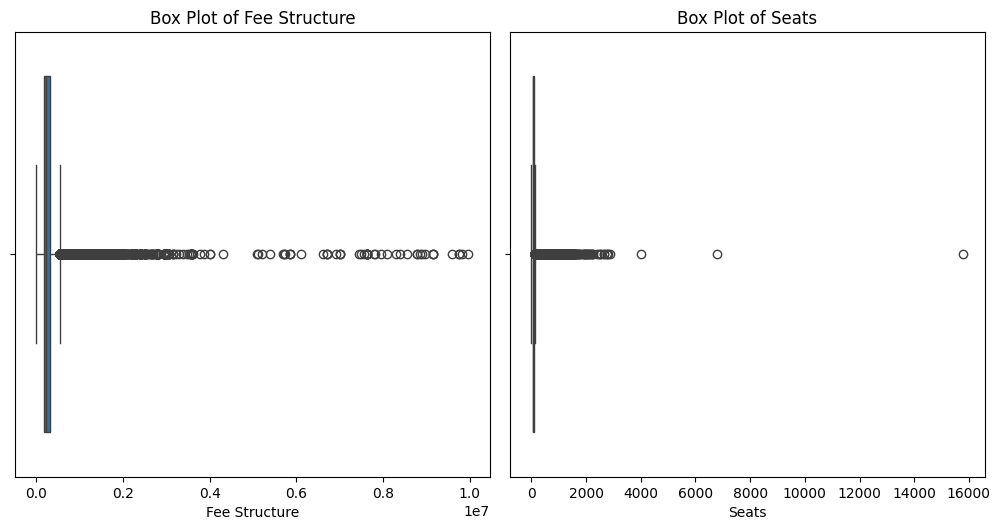

In [176]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [177]:
#Format Fee Structure to look like currency (₹ 1,000,000)
df['Fee Structure'] = df['Fee Structure'].apply(lambda x: '₹ {:,.0f}'.format(x))

#Step 1: Extract unique college details (College Name, Location, Fee Structure, Seats, College Type)
colleges_df = df[['College Name', 'Location', 'College Type']].drop_duplicates()

#Step 2: Extract more-details
courses_df = df[['College Name','Courses','Seats','Duration','Fee Structure','Facilities','Rating']]

#Step 3: Written a code to save an Excel file (.xlsm) with different sheets
with pd.ExcelWriter('normalized_data.xlsx', engine='openpyxl') as writer:
    colleges_df.to_excel(writer, sheet_name='Colleges', index=False)
    courses_df.to_excel(writer, sheet_name='Details', index=False)


In [178]:
#To save a file in Excel sheet as a (.csv)
df.to_csv('cleaned_data.csv', index=False, encoding='utf-8-sig')